In [184]:
import pandas as pd
import numpy as np
import random
import string

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, RocCurveDisplay, plot_confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from numpy import arange, argmax
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree

import matplotlib.pyplot as plt
%matplotlib inline

from numpy import mean

pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 1500)
pd.set_option("display.max_colwidth", None)

## Load the data

In [2]:
balances_df = pd.read_csv("balances.csv", sep=";")
collateral_df = pd.read_csv("collateral.csv", sep=";")
customers_df = pd.read_csv("customers.csv", sep=";")


balances_prep = pd.read_csv("balances_prep_simple_v2.csv")
balances_prep.drop("Unnamed: 0", axis=1, inplace=True)

## Transform targets

In [3]:
def new_labels(row):
    return 0 if row["prepayment_status_unique"] == "['no']" else 1

In [4]:
balances_prep["prepayment_status_unique"] = balances_prep.apply(new_labels, axis=1)

## Data Splitting

In [5]:
X = balances_prep.loc[:, ~balances_prep.columns.isin(['prepayment_status_unique'])]
Y = balances_prep["prepayment_status_unique"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=24)

In [7]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data.sort_index(inplace=True)

In [8]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)
train_data = pd.concat([X_train, y_train], axis=1)

## Feature Selection

In [9]:
features_selected = [col for col in X_train.columns if col not in ["customer_id_", 
                                                                   "account_id_", 
                                                                   "open_date_", 
                                                                   "maturity_date_min", 
                                                                   "maturity_date_max"]]

In [10]:
X_train_fs, X_test_fs = X_train[features_selected], X_test[features_selected]

## Standardize features

In [63]:
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train_fs)
X_train_scaled = pd.DataFrame(data=X_train_sc, columns=features_selected)
y_train_values = y_train.values.ravel()

In [12]:
y_train.value_counts()

0    22489
1     5048
Name: prepayment_status_unique, dtype: int64

## Modeling

### Logistic Regression

In [30]:
1- (5048 / (5048 + 22489))

0.8166830083160839

In [13]:
# lg1 = LogisticRegression(max_iter=10000)

#### Logistic Regression without weights

In [75]:
# define model
lg1 = LogisticRegression(random_state=13, max_iter=10000, class_weight=None)
# fit it
lg1.fit(X_train_scaled, y_train_values)
# test
y_pred = lg1.predict(X_test_fs)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.7558041009998305
Confusion Matrix: 
[[8423 1215]
 [1667  497]]
Area Under Curve: 0.5518018920792197
Recall score: 0.22966728280961182


#### Logistic Regression with weights

In [77]:
# # define class weights
# w = {0:1, 1:99}
w = {0:80, 1:20}


In [114]:
# define model
lg2 = LogisticRegression(random_state=13, max_iter=10000, class_weight=w)
# fit it
lg2.fit(X_train_scaled,y_train_values)
# test
y_pred = lg2.predict(X_test_fs)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.7236908998474835
Confusion Matrix: 
[[8004 1634]
 [1627  537]]
Area Under Curve: 0.5393071613863638
Recall score: 0.24815157116451017


#### Hyperparam weight search

In [45]:
# define weight hyperparameter
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [58]:
# define model
lg3 = LogisticRegression(random_state=13, max_iter=10000)# define evaluation procedure
grid = GridSearchCV(lg3,
                    hyperparam_grid,
                    scoring="roc_auc", 
                    cv=100, 
                    n_jobs=-1, 
                    refit=True)

grid.fit(X_train_scaled,y_train_values)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7884819467787116 with param: {'class_weight': {0: 1.0, 1: 1.0}}


In [72]:
grid.best_params_

{'class_weight': {0: 1.0, 1: 1.0}}

#### Building LogReg with best params only

In [65]:
# define model
lg4 = LogisticRegression(random_state=13, max_iter=10000, class_weight={0: 1.0, 1: 1.0})
# fit it
lg4.fit(X_train_scaled, y_train_values)
# test
y_pred = lg4.predict(X_test_fs)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.7558041009998305
Confusion Matrix: 
[[8423 1215]
 [1667  497]]
Area Under Curve: 0.5518018920792197
Recall score: 0.22966728280961182


#### predict with xgboost most important features only

![old_xgboost](old_xgboost_FS.png)

In [81]:
old_xgboost_FS = ["deducted_vs_principal_payment_mean", 
                  "reporting_date_count", 
                  "deducted_vs_principal_payment_max", 
                  "interest_rate_max", 
                  "customer_rating_max", 
                  "interest_rate_min", 
                  "principal_left_pctg_min", 
                  "deducted_vs_principal_payment_min"]

In [82]:
X_train_fs2, X_test_fs2 = X_train[old_xgboost_FS], X_test[old_xgboost_FS]

In [83]:
scaler = StandardScaler()

X_train_sc2 = scaler.fit_transform(X_train_fs2)
X_train_scaled2 = pd.DataFrame(data=X_train_fs2, columns=old_xgboost_FS)
y_train_values2 = y_train.values.ravel()

In [112]:
w = {0:15, 1:85}

With default weights, classifier will assume that both kinds of label error i.e. false positive (FP) and false negative (FN) have the same cost.
For majority class, will use weight of 15 and for minority class, will use weight of 85. So the penalty of wrong prediction of minority class would be 6 times more severe than wrong prediction of majority class.

In [113]:
# define model
lg5 = LogisticRegression(random_state=13, max_iter=10000, class_weight=w)
# fit it
lg5.fit(X_train_scaled2,y_train_values2)
# test
y_pred = lg5.predict(X_test_fs2)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.6699711913235045
Confusion Matrix: 
[[6304 3334]
 [ 561 1603]]
Area Under Curve: 0.6974177326425476
Recall score: 0.7407578558225508


lg2 weighted best score is 

- Accuracy Score: **0.7236908998474835**
- Area Under Curve: **0.5393071613863638**
- Recall score: **0.24815157116451017**

- Confusion Matrix: 
***[8004 1634]
-[1627  537]***




lg5 weighted best score after getting best features from old xgboost model is 

- Accuracy Score: **0.6699711913235045**
- Area Under Curve: **0.6974177326425476**
- Recall score: **0.7407578558225508**

- Confusion Matrix: 
***[6304 3334]
-[ 561 1603]***


TODO - answer questions of how I got to the feature importances of old xgboost

### Random Forest

In [144]:
rf_clf = RandomForestClassifier(n_estimators=10, class_weight='balanced')

#### Test it with all data

In [146]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=13)
# evaluate model
scores = cross_val_score(rf_clf, X_train_fs, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.975


In [147]:
rf_clf.fit(X_train_fs, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10)

In [174]:
y_pred_rf = rf_clf.predict(X_test_fs)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_rf)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_rf)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_rf)}')
print(f'Recall score: {recall_score(y_test,y_pred_rf)}')

Accuracy Score: 0.9758515505846467
Confusion Matrix: 
[[9591   47]
 [ 238 1926]]
Area Under Curve: 0.9425709769439284
Recall score: 0.890018484288355


#### Feature importances

In [149]:
rf_clf.feature_importances_

array([4.40456436e-03, 1.14906107e-02, 4.88407223e-05, 3.49535355e-05,
       5.25394634e-02, 2.31368348e-02, 1.31173235e-02, 2.23567031e-04,
       3.25866905e-04, 9.30951910e-02, 7.94286281e-03, 2.80347172e-04,
       0.00000000e+00, 0.00000000e+00, 1.02452960e-04, 1.00024488e-01,
       9.46863217e-03, 1.20552050e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.91561521e-02, 5.77172133e-02, 4.01122239e-17,
       0.00000000e+00, 2.54911052e-03, 4.57411346e-03, 4.04478716e-03,
       1.58669871e-03, 4.30138429e-03, 3.45781422e-03, 5.67494863e-04,
       5.22449760e-02, 2.46553525e-02, 2.54501390e-03, 8.05961798e-02,
       4.34634594e-03, 5.75496057e-03, 4.11603828e-03, 3.16209363e-03,
       2.04969954e-02, 5.87404885e-03, 1.36278305e-02, 1.38564589e-02,
       7.17694574e-03, 7.75780541e-03, 6.94512016e-03, 5.78625056e-03,
       1.51339603e-02, 5.52384546e-02, 1.64705518e-02, 1.29403488e-02,
       4.43634980e-02, 2.09738366e-02, 1.03817513e-01, 6.74459461e-03,
      

<AxesSubplot:>

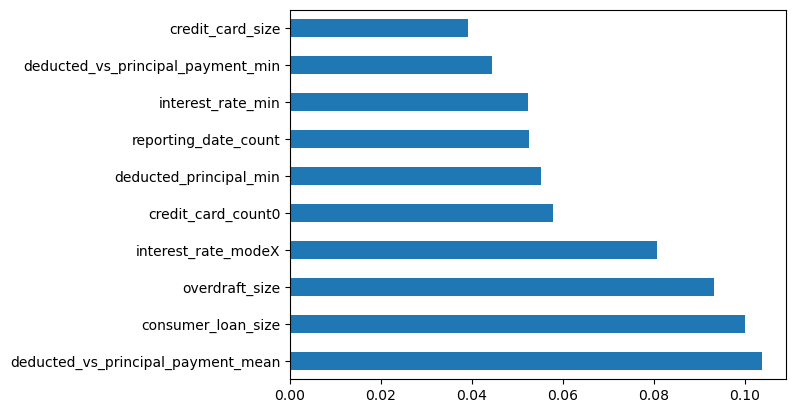

In [150]:
rf_feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train_fs.columns)
rf_feat_importances.nlargest(10).plot(kind='barh')

In [155]:
rf_best_feat_importances = list(rf_feat_importances.nlargest(10).index)
rf_best_feat_importances

['deducted_vs_principal_payment_mean',
 'consumer_loan_size',
 'overdraft_size',
 'interest_rate_modeX',
 'credit_card_count0',
 'deducted_principal_min',
 'reporting_date_count',
 'interest_rate_min',
 'deducted_vs_principal_payment_min',
 'credit_card_size']

#### Test it with xgboost selected features

In [124]:
rf_clf2 = RandomForestClassifier(n_estimators=10, class_weight='balanced')

In [125]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=13)
# evaluate model
scores = cross_val_score(rf_clf, X_train_fs2, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.972


In [129]:
rf_clf2.fit(X_train_fs2, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=10)

In [130]:
y_pred = rf_clf2.predict(X_test_fs2)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.9720386375190646
Confusion Matrix: 
[[9581   57]
 [ 273 1891]]
Area Under Curve: 0.9339653209588202
Recall score: 0.8738447319778189


## Decision Trees

### Default

In [157]:
# define model
tree_clf = DecisionTreeClassifier()

In [158]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(tree_clf, X_train_fs, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.937


In [160]:
tree_clf.fit(X_train_fs, y_train)

DecisionTreeClassifier()

In [176]:
y_pred_tree1 = tree_clf.predict(X_test_fs)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_tree1)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_tree1)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_tree1)}')
print(f'Recall score: {recall_score(y_test,y_pred_tree1)}')

Accuracy Score: 0.9621250635485511
Confusion Matrix: 
[[9406  232]
 [ 215 1949]]
Area Under Curve: 0.9382877829939177
Recall score: 0.9006469500924215


### Using rf_best_features

In [162]:
# define model
tree_clf2 = DecisionTreeClassifier()

In [163]:
X_train_fs3, X_test_fs3 = X_train[rf_best_feat_importances], X_test[rf_best_feat_importances]

In [164]:
scaler = StandardScaler()

X_train_sc3 = scaler.fit_transform(X_train_fs3)
X_train_scaled3 = pd.DataFrame(data=X_train_fs3, columns=rf_best_feat_importances)
y_train_values3 = y_train.values.ravel()

In [166]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(tree_clf2, X_train_fs3, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.873


In [168]:
tree_clf2.fit(X_train_fs3, y_train)

DecisionTreeClassifier()

In [182]:
y_pred_tree2 = tree_clf2.predict(X_test_fs3)# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_tree2)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_tree2)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_tree2)}')
print(f'Recall score: {recall_score(y_test,y_pred_tree2)}')

Accuracy Score: 0.9223013048635824
Confusion Matrix: 
[[9179  459]
 [ 458 1706]]
Area Under Curve: 0.8703654549785412
Recall score: 0.788354898336414


## Plots

C:\Users\Mitko\.conda\envs\ss2022\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


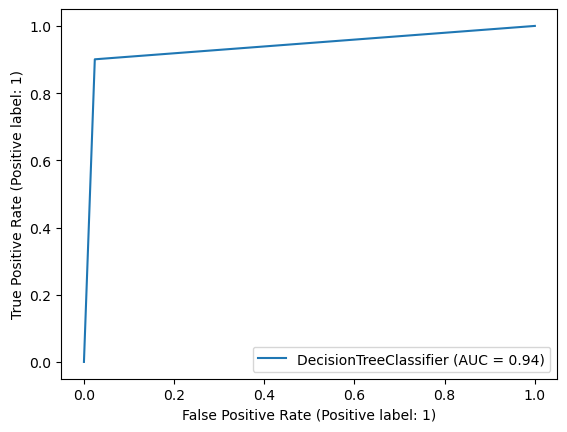

In [171]:
metrics.plot_roc_curve(tree_clf, X_test_fs, y_test) 

plt.show()

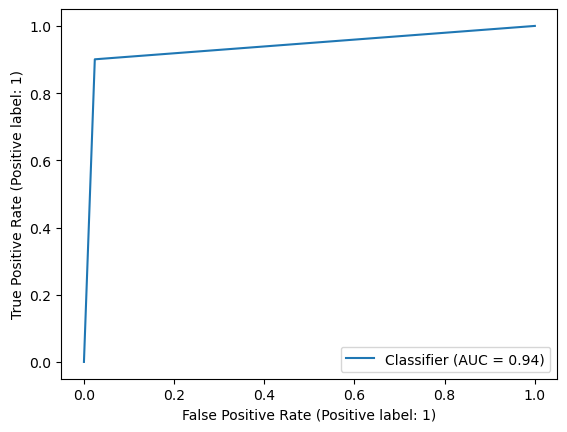

In [203]:
# RocCurveDisplay.from_predictions(y_test, y_pred_rf)
RocCurveDisplay.from_predictions(y_test, y_pred_tree1)
# RocCurveDisplay.from_predictions(y_test, y_pred_tree2)
plt.show()

In [204]:
# tree.plot_tree(tree_clf2, max_depth=5)
# plt.show()

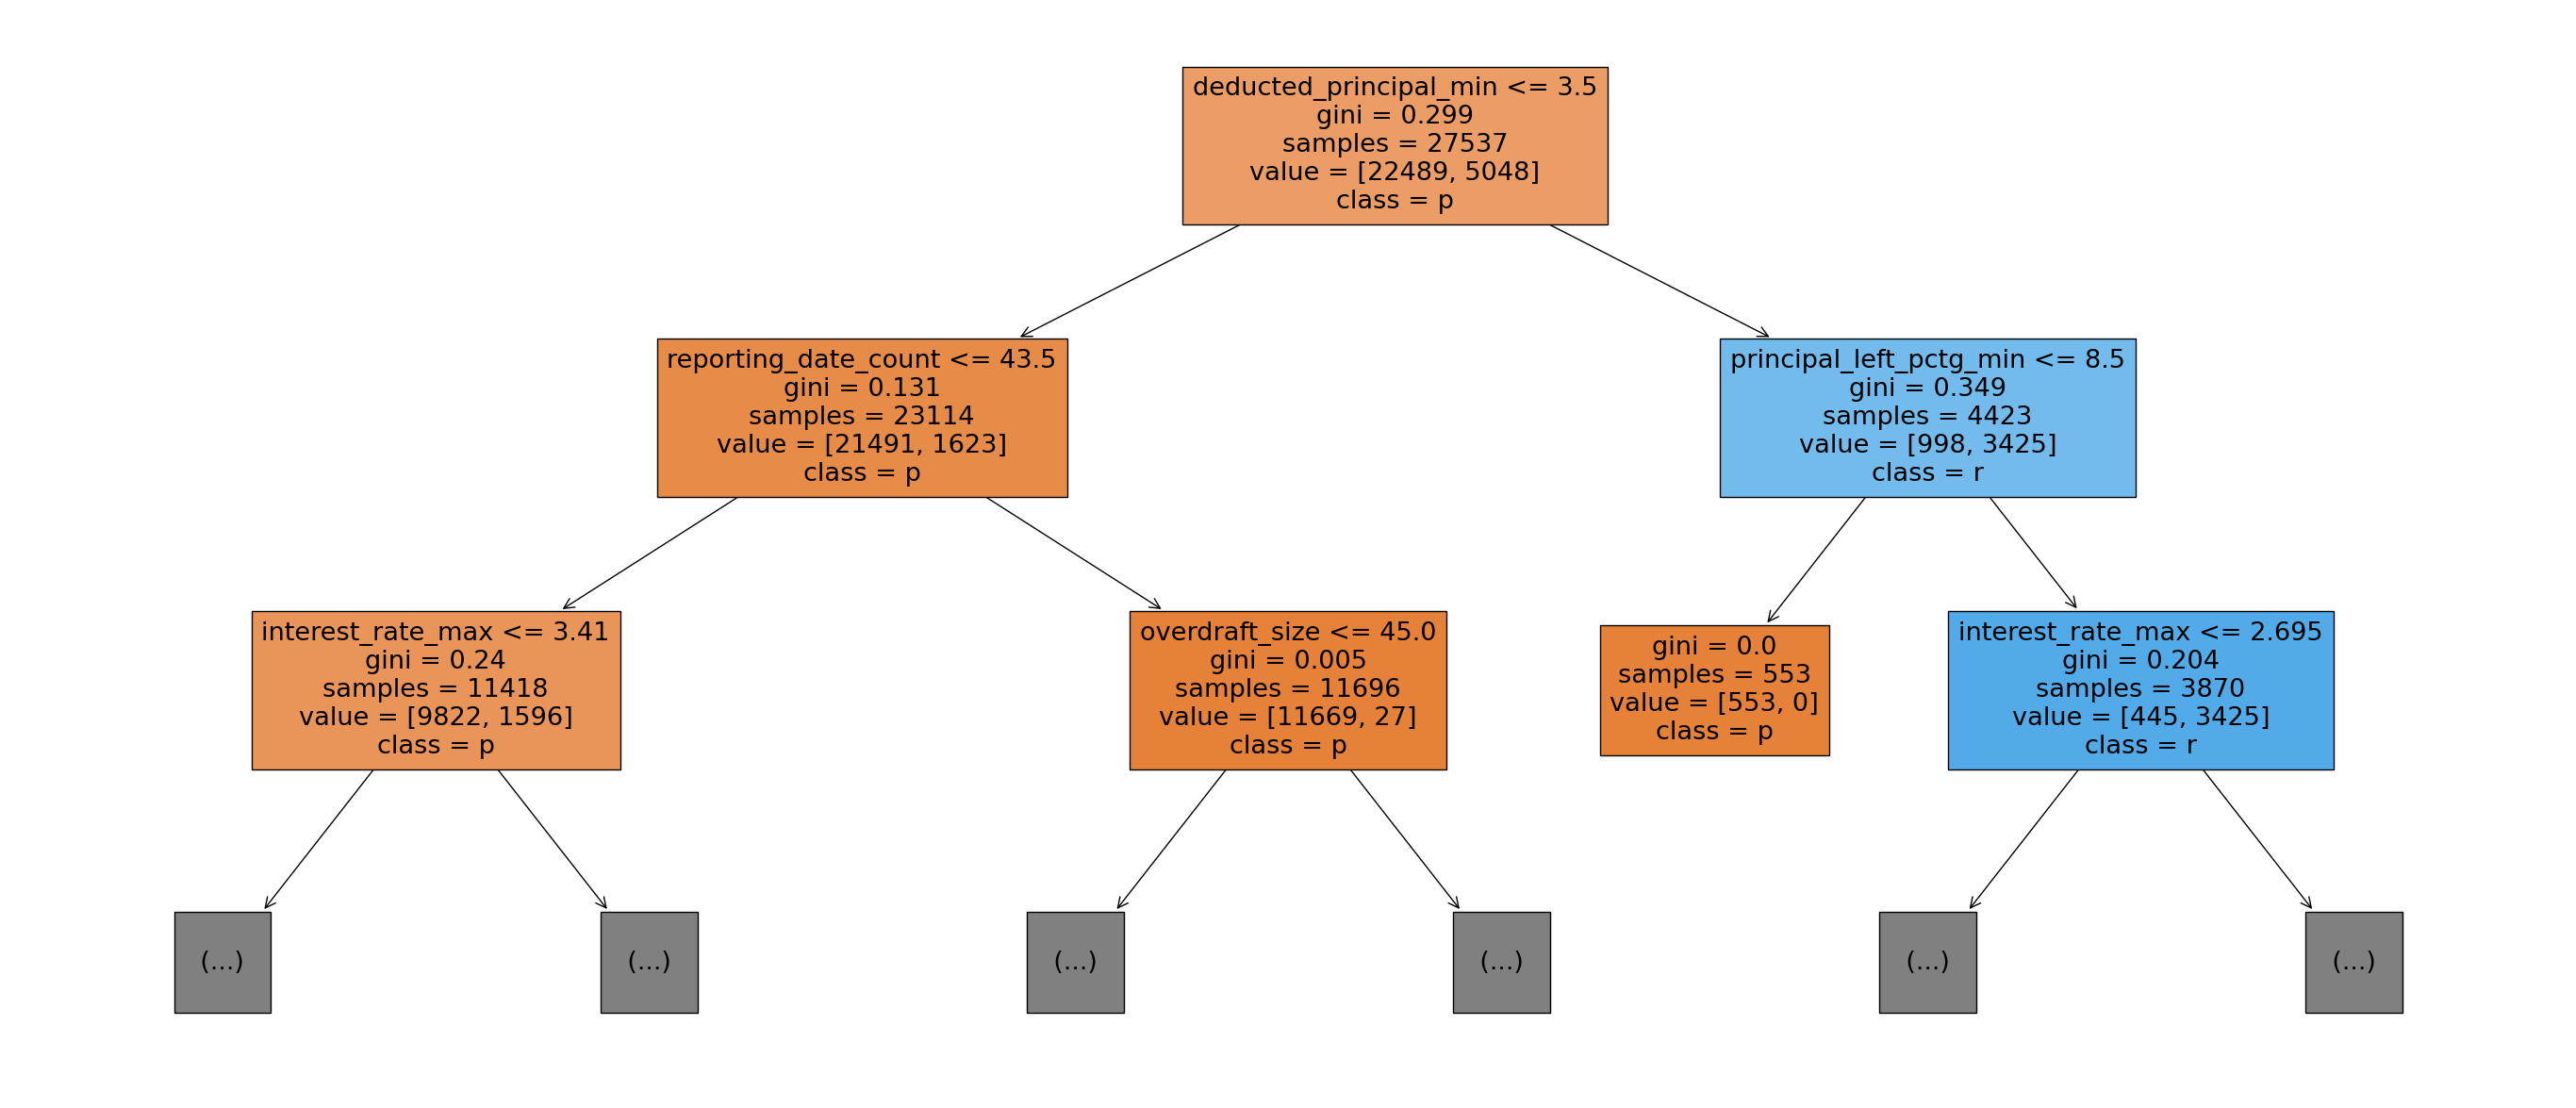

In [201]:
fig = plt.figure(figsize=(35,15))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_test_fs.columns,  
                   class_names=y_test.name,
                   filled=True,
                  max_depth=2)


In [202]:
fig.savefig("decistion_tree1.png")